# Question

We have two sets of date:
1- Prediction data in a series of Excel files
2- Actual data in a seperated Excel file
.
Analyse the data and find whcih prediction is more valuable

In [1]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Forcast Data

In [2]:
# Create file list
files = glob(os.path.join('data/', '*.xlsx'))

load_df = None
for file in files:
    # Extract data from Excel file.
    raw_df = pd.read_excel(file, sheet_name='MISO', skiprows=4, nrows=17, usecols = range(7), index_col=0, engine='openpyxl')
    
    # Get data
    projected_load = raw_df.loc['Projected Load', :].to_list()
    
    # Get row label
    date = pd.to_datetime(file.split('\\')[-1].split('_')[0])
    
    # Create column labels
    labels = [f'Prediction for today+{d}' for d in range(1,7)]
    
    # Create dictionaries
    load_dict = {col: val for col, val in zip(labels, projected_load)}
    
    # Create dataframes
    if load_df is None:
        load_df = pd.DataFrame.from_records(data=load_dict, index=[date])
    else:
        load_df = load_df.append(pd.DataFrame.from_records(data=load_dict, index=[date]))
    
# Sort dataframes
load_df.sort_index(inplace=True)

# Set index column name
load_df.index.name = "Date"
    

C:\Users\mafar\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\mafar\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\mafar\AppData\Local\Temp\ipykernel_48376\1165949777.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  load_df = load_df.append(pd.DataFrame.from_records(data=load_dict, index=[date]))
C:\Users\mafar\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\mafar\AppData\Local\Temp\ipykernel_48

# Load Actual Data

In [3]:
# Extract data from excel file
df = pd.read_excel('data/20210204_rfal_HIST.xls', skiprows=4, usecols = range(1, 6))

# Drop null records
df.dropna(inplace=True)

# Filter, group and evaluate the average
miso_mean = df[df['Region'] == 'MISO'].groupby('Market Day').mean()

# Change index column datatype
miso_mean.index = pd.to_datetime(miso_mean.index)

# Sort dataframes
load_df.sort_index(inplace=True)

# Filter based on the first available prediction date
miso_mean = miso_mean[miso_mean.index >= load_df.index[0]]

# Analysis



Text(0, 0.5, 'Load (MWh)')

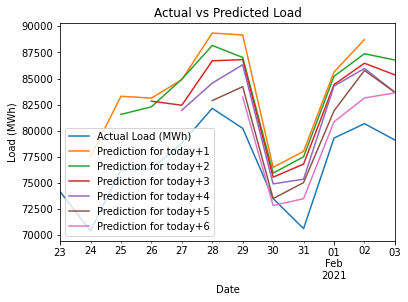

In [4]:
# Concatenate
load_df = pd.concat([miso_mean['Actual Load (MWh)'], load_df], axis=1)

# Plot
load_df['Actual Load (MWh)'].plot(legend=True)
for c in range(1, 7):
    load_df.iloc[:, c].shift(c).plot(legend=True)

plt.title("Actual vs Predicted Load")
plt.xlabel('Date')
plt.ylabel('Load (MWh)')

All predictions are higher than actual values.
Let's check which prediction day is closer to the reality.

<AxesSubplot:>

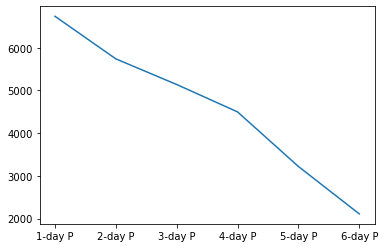

In [5]:
# Shift data
load_shift_df = None
load_shift_df = load_df['Actual Load (MWh)']
for c in range(1, 7):
    load_shift_df = pd.concat([load_shift_df, load_df.iloc[:, c].shift(c)], axis=1)

# Remove null values
load_shift_df.dropna(inplace=True)

# Calculate difference
load_diff_df = None
for c in range(1, 7):
    load_diff_df = pd.concat([load_diff_df, abs(load_shift_df.iloc[:, c] - load_shift_df['Actual Load (MWh)'])], axis=1)
    
# Assign column names
load_diff_df.columns = [f'{d}-day P' for d in range(1,7)]

# Calculate mea
load_mean_diff_df = load_diff_df.mean()

# Plot
sns.lineplot(data=load_mean_diff_df)

So the 6-days predcition as closer to the reality.